In [1]:
import numpy as np
from tqdm import tqdm, trange
from scipy.sparse import coo_matrix, hstack,vstack
from scipy.interpolate import griddata

from scipy.optimize import fsolve
from scipy import integrate
import sympy as sp

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
import time
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import deepxde as dde
from timeit import default_timer
import datetime
import os



Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
def solveBetaFunction(x, gamma, amp, callback1, callback2):
    beta = np.zeros(len(x))
    for idx, val in enumerate(x):
        beta[idx] = amp*callback1(gamma*callback2(val))
    return beta

def tauFunc(val, gamma, amp):
    return (amp * gamma) * np.exp(-gamma * val)



def gFunc(x, gamma, amp):
    return x - tauFunc(x, gamma, amp)


def inverse_function(y, gamma, amp):
    result = fsolve(lambda x: gFunc(x, gamma, amp) - y, np.zeros(len(y)))
    return result

def numerical_derivative(f, x, gamma, amp):
    h = 1e-5
    df = (f(x + h, gamma, amp) - f(x - h, gamma, amp)) / (2 * h)
    return df
    
def cFunc(x):
    return 20 - 20 * x

def fFunc(x, y):
    return 5 * np.cos(2 * np.pi * x) + 5 * np.sin(2 * np.pi * y) 

def buildF(x):
    s_cood, q_cood = np.meshgrid(x, x, indexing="ij")
    return fFunc(s_cood, q_cood)

def get_cof_equ_K_19(i, N1, f1_m, hx, a):
    num = N1 - i - 2
    coff = f1_m[i, i+1:N1-1].T
    cofi1 = coo_matrix((2 * np.ones(num), (range(num), range(num))), shape = (num, num)).tocsr()
    cofi1 = cofi1 + coo_matrix((-1 * np.ones((num - 1)), (range(num - 1),range(1, num))),shape = (num, num)).tocsr()
    cofi3_1 = np.tril(np.ones((num, num))) - np.diag(1 / 2 * np.ones(num))
    cofi3_1 = hx * cofi3_1
    cofi3_2 = np.zeros((num,num))
    for k in range(num):
        cofi3_2[k, 0:k] = f1_m[i + 1: i + k + 1, i + k + 1].T
    cofi3 = -hx / (a) * cofi3_1 * cofi3_2
    cofi = cofi1 + coo_matrix(cofi3).tocsr() 
    return cofi, coff

def KernelCalc2(a , hx, f1_m): 
    fii = np.diag(f1_m)
    cofmed = np.zeros((N1, N1))
    cofmed[:, -1] = 1/ 2 * np.ones((1, N1))
    cof_int_zeta_1 = hx * (np.triu(np.ones((N1, N1))) - cofmed - np.diag(1 / 2 * np.ones(N1)))
    K_ii = -1 / a * np.dot(cof_int_zeta_1, fii)
    K = np.diag(K_ii)

    for i in range(N1 - 3, -1, -1 ):
        [cofi, coff] = get_cof_equ_K_19(i,N1,f1_m,hx,a)
        Kibud = K[i, i] * hx * hx / (2 * a) - hx / a
        Ki = np.linalg.solve(cofi.toarray(), K[i+1,i+1:N1-1].T) + np.linalg.solve(cofi.toarray(), np.dot(Kibud, coff))
        K[i, i+1:N1-1]=Ki.T  
    Kbud = K[0, :]
    return K, Kbud 

def iteration_k(iterationNum, gBar, gamma, amp):
    #case 0<s<\bar{g} for \Delta K0
    s, q = np.meshgrid(spatial, spatial, indexing="ij")
    k_0 = np.zeros((N1, N1))
   
    for i in range(N1):
        for j in range(i, N1):

            ff = lambda theta: 5 * np.cos(2 * np.pi * (theta + s[i, j] - q[i, j])) + 5 * np.sin(2 * np.pi * theta) 
            if s[i, j] - q[i, j] + 1 < gBar:
                g_inverse_s_q_1 = inverse_function([s[i, j] - q[i, j] + 1], gamma, amp)
                g_diff_at_g_inverse_s_q_1 = numerical_derivative(gFunc, g_inverse_s_q_1, gamma, amp)
                k_0[i, j]= -1 * integrate.quad(ff, q[i, j], 1)[0] - cFunc(g_inverse_s_q_1) / g_diff_at_g_inverse_s_q_1
            else:
                k_0[i, j]= -1 * integrate.quad(ff, q[i, j], 1)[0]

    simpsonIntCoe = np.ones((N1, N1))
    simpsonIntCoe[0, :] = 0.5
    simpsonIntCoe[-1, :] = 0.5
    simpsonIntCoe[:, 0] = 0.5
    simpsonIntCoe[:, -1] = 0.5
    
    kSum = k_0
    K_iteration = k_0
    for _ in range(iterationNum):
        K_iteration_temp = np.zeros((N1, N1))
        for ii in range(N1):#s
            for jj in range(ii, N1):#q
                mSequence = np.linspace(0, 1 - q[ii, jj], N1)
                dm = abs(mSequence[2] - mSequence[1])
                rSequence = np.linspace(s[ii, jj], q[ii, jj], N1)
                dr = abs(rSequence[2]-rSequence[1])
                
                mMatrix, rMatrix = np.meshgrid(mSequence, rSequence, indexing="ij")
                f_obj = fFunc(mMatrix + rMatrix, mMatrix + q[ii, jj]) 
                
                x_qCoodinate = np.hstack((s.flatten()[:,None], q.flatten()[:,None]))
                k_obj = griddata(x_qCoodinate, K_iteration.ravel(), (mMatrix + s[ii, jj], mMatrix + rMatrix), method="linear", fill_value = 0)
                
                if s[ii, jj] -q[ii, jj] + 1 < gBar:
                    g_inverse_s_q_1 = inverse_function([s[ii, jj] - q[ii, jj] + 1],gamma, amp)
                    rrSequence = np.linspace(g_inverse_s_q_1, 1, N1)
                    drr = abs(rrSequence[2] - rrSequence[1])

                    k2_obj = griddata(x_qCoodinate, K_iteration.ravel(), (tauFunc(gamma, amp, rrSequence) + s[ii, jj] - q[ii, jj] + 1, rrSequence), method="linear", fill_value = 0)
                    K_iteration_temp[ii, jj] = np.sum(dm * dr * f_obj * k_obj * simpsonIntCoe) + np.trapz( k2_obj.squeeze() * cFunc(rrSequence).squeeze(), dx = drr)
                else:
                    K_iteration_temp[ii, jj] = np.sum(dm * dr * f_obj * k_obj * simpsonIntCoe)


        K_iteration = K_iteration_temp      
        kSum =  kSum + K_iteration_temp
    return kSum, kSum[0, :]


def get_cof_1(ht,hx,N,a,f_m1,c,tau):
    N1=N+1
    cof_int_zeta_1_Nplus1 = get_cof_int_zeta_1(N1,hx)
    cof_int_zeta_1 = cof_int_zeta_1_Nplus1 
    cof_int_zeta_1[0, :] = 0
    C1 = a * ht / hx
    Nsquare = (N1) * N
    At1 = coo_matrix(((1-C1) * np.ones(N), (range(1, N1), range(1, N1))),shape = (N1, N1)).tocsr()
    At1 = At1 + coo_matrix((C1 * np.ones(N), (range(1, N1), range(N1-1))),shape = (N1, N1)).tocsr()
    At1 = At1 + ht * coo_matrix(cof_int_zeta_1 * f_m1).tocsr()

    At2 = coo_matrix((N1,Nsquare)).tocsr()
    At2 = At2 + coo_matrix((c[1 : N+1] * ht, (range(1, N1), range(N, N * (N + 1), N))), shape = (N1, Nsquare)).tocsr()
    tauuu = (np.array(tau) * np.ones((N,N+1))).reshape((-1, 1), order = "f")

    ee = ht / (hx * tauuu)
    diag_vale_c = (1 - ee).squeeze()
    diag_vale_l = ee.squeeze()
    diag_vale_l[N - 1 : Nsquare : N] = 0
    diag_vale_l = np.delete(diag_vale_l, -1)

    At4 = coo_matrix((diag_vale_c, (range(Nsquare), range(Nsquare))), shape = (Nsquare,Nsquare)).tocsr()
    At4 = At4 + coo_matrix((diag_vale_l, (range(Nsquare - 1), range(1, Nsquare))),shape = (Nsquare, Nsquare)).tocsr()

    eee = ee[0 : Nsquare : N].squeeze()

    At3 = coo_matrix((eee, (range(N - 1, Nsquare, N), N1 * [N])), shape = (Nsquare, N1)).tocsr()
    Aa1 = vstack((At1, At3))
    Aa2 = vstack((At2, At4))

    return hstack((Aa1, Aa2))

def datasetGenerate(num, num2, nx, spatial, finalTime, tTotal):
    inputArr1 = []
    output_arr = []

    ht = finalTime / (tTotal - 1)
    sunNum = tTotal * num * num2
    pbar = tqdm(total=sunNum)
    for i in range(num):
        gamma = np.random.uniform(0.8, 2.4)
        amp = np.random.uniform(0.4, 0.8)
        tauTemp = tauFunc(spatial, gamma, amp)
        A2 = get_cof_1(ht, dx, N, a, f1_m, cFunc(spatial), tauTemp)
        K, Kbud = iteration_k(4, gFunc(1, gamma, amp), gamma, amp)
        

        g_inverse_value = inverse_function(spatial, gamma, amp)
        g_inverse_0 = g_inverse_value[0]
        
        for j in range(num2):#x的样本              
            if j > (num2 / 2):               
                gamma2 = np.random.uniform(3, 10)
                amp2 = np.random.uniform(4, 10)
            else:
                gamma2 = np.random.uniform(1, 5)
                amp2 = np.random.uniform(0.1, 4)   

            bias = np.random.uniform(0, 0.5) 
            xuSpace = np.zeros((nx ** 2, tTotal))#保存x，u
            xuSpace[:nx, 0] = amp2 * np.cos(gamma2 * np.arccos(spatial - bias)) 

            
            for tIndex in range(tTotal-1):
                tIndex1 = tIndex + 1
                xuSpace[:, tIndex1] = A2 @ xuSpace[:, tIndex] 
                pbar.update(1)#每次循环增加1个点
            
                uuTemp = xuSpace[nx:, tIndex].reshape((N, N1), order = "f").T
                uuTemp = np.hstack((uuTemp, xuSpace[N, tIndex] * np.ones((N1,1))))
                xuTemp = xuSpace[:nx, tIndex]
                U = solve_contrl_U(uuTemp, K, Kbud, xuTemp, gamma, amp, g_inverse_0) 
                xuSpace[0, tIndex1] = U
                temp1 = np.tile(tauTemp, (nx, 1))
                temp2 = np.tile(xuTemp, (nx, 1))
                temp3 = np.array([uuTemp, temp1, temp2])
                inputArr1.append(temp3.flatten())
                output_arr.append(U)
                
    pbar.close()
    np.savetxt("../dataset/input1025.dat", inputArr1)
    np.savetxt("../dataset/output1025.dat", output_arr)
    print("Save")
    return 


def coefficient_matrix(length):#contrl3
    obj_matrix = np.triu(np.ones((length, length))) - np.diag(0.5 * np.ones(length))
    obj_matrix[0, :] = 1 / 2
    obj_matrix[:, -1] = 1 / 2
    return obj_matrix * dx * dx


def solve_contrl_U(uu, K,  Kbud, xu, gamma, amp, g_inverse_0):
    x_star = np.hstack((zeta1_m.flatten()[:,None], eta1_m.flatten()[:,None])) 
    #control1
    contrl1 = np.trapz(Kbud * xu, dx = dx)
    
    #control2
    sequence2 = np.linspace(0, g_inverse_0, N1)
    dx2 = abs(sequence2[1]-sequence2[2])
    u2_temp_y = sequence2 / (tauFunc(sequence2, gamma, amp))
    u2_x, u2_y = np.meshgrid(sequence2, u2_temp_y, indexing="ij")
    u2 = np.diag(griddata(x_star, uu.ravel(), (u2_x, u2_y), method="cubic", fill_value = 0))
    contrl2 = np.trapz(cFunc(sequence2) * u2 , dx = dx2)
    
        
    #control3
    sequence3 = np.linspace(g_inverse_0, 1, N1)
    dx3 = sequence3[1] - sequence3[0]
    coe3 = np.tril(np.ones((N1, N1))) - np.diag(0.5 * np.ones(N1)) 
    coe3[0, :] = 0.5
    coe3[:, -1] = 0.5
    coem3 = coe3 * dx3 * dx3
    
    u3_x, u3_y_0 = np.meshgrid(sequence3, sequence3, indexing="ij") 
    u3_y = u3_x / tauFunc(u3_x, gamma, amp)#\frac{p}{\tau (q)}

    u3 = griddata(x_star, uu.ravel(), (u3_x, u3_y), method="cubic", fill_value = 0)  
    K_control3 = griddata(x_star, K.ravel(), (u3_x, u3_y_0), method="cubic", fill_value = 0)
    c_m3 = np.tile(cFunc(sequence3), (N1, 1))
    contrl3 = np.sum(c_m3 * K_control3 * u3 * coem3)
    
    #control4
    sequence4 = sequence2
    dx4 = dx2
    coe4 = np.tril(np.ones((N1, N1))) - np.diag(0.5 * np.ones(N1)) 
    coe4[0, :] = 0.5
    coe4[:, -1] = 0.5
    coem4 = coe4 * dx4 * dx4
    
    u4_x, u4_y_0 = np.meshgrid(sequence4, sequence4, indexing="ij") 
    u4_y = u4_x / tauFunc(u4_x, gamma, amp)#\frac{p}{\tau (q)}
    u4 = griddata(x_star, uu.ravel(), (u4_x, u4_y), method="cubic", fill_value = 0)  
    K_control4 = griddata(x_star, K.ravel(), (u4_x, u4_y_0), method="cubic", fill_value = 0)
    c_m4 = np.tile(cFunc(sequence4), (N1, 1))
    contrl4 = np.sum(c_m4 * K_control4 * u4 * coem4)

    U = contrl1 - contrl2 + contrl3 + contrl4
    return U

def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def get_cof_int_zeta_1(N,hx):
    cofmed = np.zeros((N,N))
    cofmed[:, N - 1] = 1 / 2 * np.ones((1,N))
    cof_int_zeta_1 = hx * (np.triu(np.ones((N,N))) - cofmed - np.diag(1 / 2 * np.ones(N)))
    return cof_int_zeta_1


In [3]:
np.random.seed(0)
a = 1
X = 1
dx = 1 / 20
nx = int(round(X/dx))+1
spatial = np.linspace(0, X, nx, dtype=np.float32)
N1 = len(spatial)
N = N1 - 1
# Parameters
epochs =300
ntrain = 900
ntest = 100

gammaS = 0.5
learning_rate = 0.00001
step_size= 40
modes=12
width=32
batch_size = 50

In [4]:

[eta1_m, zeta1_m]= np.meshgrid(spatial,spatial)
f1_m = buildF(spatial)
fii = np.diag(f1_m)
timeTest = 10
pointTest = 2001
recount = True

In [5]:
if recount == True:
    datasetGenerate(15, 20, nx, spatial, timeTest, pointTest)
    print("Date is:", datetime.datetime.now())

  0%|          | 0/600300 [00:00<?, ?it/s]

100%|█████████▉| 600000/600300 [2:15:25<00:04, 73.84it/s]   


Save
Date is: 2024-10-29 19:51:06.417141


In [6]:
sub_xy =  1
inpArr1 = np.loadtxt("../dataset/input1025.dat", dtype=np.float32)
outArr = np.loadtxt("../dataset/output1025.dat", dtype=np.float32)

xxx = inpArr1[::sub_xy, :]
yyy = outArr[::sub_xy]



x_train, x_test, y_train, y_test = train_test_split(xxx, yyy, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))


In [7]:

################二维网格###############
grids = []
grids.append(np.linspace(0, 1, nx, dtype=np.float32))
grids.append(spatial * spatial)
grid2 = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T  
grid2 = torch.from_numpy(grid2).cuda()
class BranchNet(nn.Module):
    def __init__(self, shape):#shape = nx
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(3, 64, 5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(64, 128, 5, stride=2)
        self.fc1 = torch.nn.Linear(1152, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 3, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)   
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        return x
    
class DeepONetModified(nn.Module):
    def __init__(self, m2, branch_2dim, dim_x, projection):#project=1
        super(DeepONetModified, self).__init__()
        self.net1 = dde.nn.DeepONetCartesianProd([m2, branch_2dim], [dim_x, 64 ,128, 256, 256], "relu", "Glorot normal").cuda()
        self.fc3 = torch.nn.Linear(441, 256)
        self.relu = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, projection)
        

    def forward(self, x):
        x, grid = x[0], x[1]
        x = self.net1((x, grid))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return self.fc5(x)

m2 = nx * nx
projection = 1
model = DeepONetModified(m2, BranchNet(nx),  2, projection).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

#loss = torch.nn.MSELoss()
loss = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0)
train_lossArr = []
test_lossArr = []
time_Arr = []


In [8]:
print("Start to train")
for ep in trange(epochs):
    t1 = default_timer()
    model.train()
    t1 = default_timer()
    train_loss = 0
    for xxTemp, yyTemp in trainData:
        xx, y1 = xxTemp.cuda(), yyTemp.cuda()
        optimizer.zero_grad()

        out = model((xx, grid2))
        lp = loss(out.view(batch_size, -1), y1.view(batch_size, -1))
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():#测试集
        for xxTemp, yyTemp in testData:
            xx, y1 = xxTemp.cuda(), yyTemp.cuda()
            out = model((xx, grid2))
            test_loss += loss(out.view(batch_size, -1), y1.view(batch_size, -1)).item()

            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)


print("eend")

torch.save(model.state_dict(), "../module/modedlNet1025.pt")
print("Date is ", datetime.datetime.now())

Start to train


  0%|          | 1/300 [00:24<2:04:24, 24.96s/it]

0 24.96343949995935 0.17439619507941476 0.034900450079755195


 17%|█▋        | 51/300 [22:11<1:51:31, 26.87s/it]

50 26.55745256890077 0.0006123108801315354 0.0007086408885591785


 34%|███▎      | 101/300 [44:08<1:28:05, 26.56s/it]

100 27.028114176006056 0.00022281858781906505 0.0003280591439363434


 50%|█████     | 151/300 [1:05:36<58:58, 23.75s/it]  

150 24.65665593603626 0.0001507125827321766 0.0002903225051214046


 67%|██████▋   | 201/300 [1:24:49<38:20, 23.24s/it]

200 23.441725465934724 0.00011969762434967345 0.0002587480865724956


 84%|████████▎ | 251/300 [1:44:05<18:53, 23.13s/it]

250 23.6021661789855 0.00011337372950966032 0.0002547646879748792


100%|██████████| 300/300 [2:03:04<00:00, 24.62s/it]

eend
Date is  2024-10-29 21:56:12.444356


<Figure size 800x600 with 0 Axes>

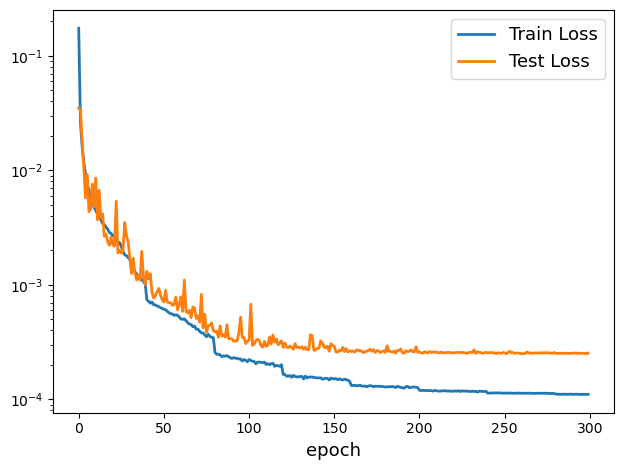

In [9]:
my_dpi = 600
fig = plt.figure(figsize=(800 / my_dpi, 600 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  
flg, ax = plt.subplots()
ax.plot(train_lossArr, label="Train Loss", linewidth=2)
ax.plot(test_lossArr, label="Test Loss", linewidth=2)
#$'r'$\lVert x\left( \zeta ,t \right) \rVert _{L2}$'
plt.xlabel('epoch',fontsize="13")
plt.tick_params(labelsize=10)
fig = plt.gcf()
fig.tight_layout()
plt.legend(fontsize="13", loc="best")
plt.yscale("log")

plt.savefig('../picture2/trainLoss.jpg', dpi=500,bbox_inches='tight')
plt.show()

In [10]:

model2 = DeepONetModified(m2, BranchNet(nx),  2, projection).cpu()

if os.path.exists("../module/modedlNet1025.pt"):
    model2.load_state_dict(torch.load("../module/modedlNet1025.pt", map_location = 'cpu'))
    #optimizer.load_state_dict(torch.load("/home/dhu422/Humjacky/Important/Tau2U/model/optimizer.pt"))
    #model = model.cpu()
    print("Model on device：", next(model2.parameters()).device)#查看模型所在的设备
    print("Success！")
    
girdEstimate = grid2.cpu()


Model on device： cpu
Success！


In [11]:
final_time = 20

ht = timeTest / (pointTest - 1)
Maxstep = int(final_time / ht)
myTime = np.linspace(0, final_time, Maxstep + 1) 

gammaTest = 1.6
ampTest = 0.5
tauTrue = tauFunc(spatial, gammaTest, ampTest)
g_bar = gFunc(1, gammaTest, ampTest)

UCalc = np.zeros(Maxstep)
UEstimate = np.zeros(Maxstep)
UEstimate2 = np.zeros(Maxstep)
lossU = np.zeros(Maxstep, dtype=np.float16)
x_u = np.zeros((N1 ** 2, Maxstep + 1))

A = get_cof_1(ht, dx, N, a, f1_m, cFunc(spatial), tauTrue)

In [12]:
start_time1 = time.time()

xx2 = 3 * np.cos(4 * np.arccos(spatial - 0.3)) 
#xx2 = 3 * np.sin(2 * np.pi * spatial)
uu = np.zeros((N * N1, 1)).squeeze()
x_u[:, 0] = np.hstack((xx2, uu))
xx_uu = x_u[:, 0]
for tt in trange(Maxstep):

    uu_temps1 = np.around(xx_uu[N1 : ].reshape((N, N1), order = "f"), 9).T
    uu_temps1 = np.hstack((uu_temps1, xx_uu[N1 - 1] * np.ones((N+1,1)))) 

    with torch.no_grad():
        TauArray = np.tile(tauTrue, (nx, 1))
        xArray = np.tile(xx_uu[:N1], (nx, 1))
        Input = np.array([uu_temps1, TauArray, xArray], dtype=np.float32).flatten()
        Input = torch.from_numpy(np.expand_dims(Input, 0)).cpu()
        UEstimate[tt] = model2((Input, girdEstimate))
    
    xx_uu = A @ x_u[:, tt]   
    xx_uu[0] = UEstimate[tt]
    
    x_u[:, tt+1] = xx_uu
    
X = x_u[0 : N1, :]
[Time, Zeta] = np.meshgrid(myTime, spatial)

end_time1 = time.time()
execution_time = end_time1 - start_time1
print("NO consume time:", execution_time)

100%|██████████| 4000/4000 [02:24<00:00, 27.71it/s]

NO consume time: 144.3517141342163


In [13]:
start_time2 = time.time()

x_u2 = np.zeros((N1 ** 2, Maxstep + 1))
uu2 = np.zeros((N * N1, 1)).squeeze()
x_u2[:, 0] = np.hstack((xx2, uu2))
xx_uu2 = x_u2[:, 0]
K, Kbud = iteration_k(5, g_bar, gammaTest, ampTest)
g_inverse_value = inverse_function(spatial, gammaTest, ampTest)
g_inverse_0 = g_inverse_value[0]

for tt in trange(Maxstep):
    uu_temps2 = np.around(xx_uu2[N1 : ].reshape((N, N1), order = "f"), 5).T
    uu_temps2 = np.hstack((uu_temps2, xx_uu2[N1 - 1] * np.ones((N+1,1))))   

    UCalc[tt] = solve_contrl_U(uu_temps2, K, Kbud, xx_uu2[:N1], gammaTest, ampTest, g_inverse_0)


    xx_uu2 = A @ x_u2[:, tt]   
    xx_uu2[0] = UCalc[tt]
    x_u2[:, tt+1] = xx_uu2

end_time2 = time.time()
execution_time2 = end_time2 - start_time2
print("NO consume time:", execution_time2)


X2 = x_u2[0 : N1, :]
[Time, Zeta] = np.meshgrid(myTime, spatial)

100%|██████████| 4000/4000 [00:46<00:00, 85.92it/s]

NO consume time: 50.53999662399292


0.01656


<Figure size 800x800 with 0 Axes>

<Figure size 640x480 with 0 Axes>

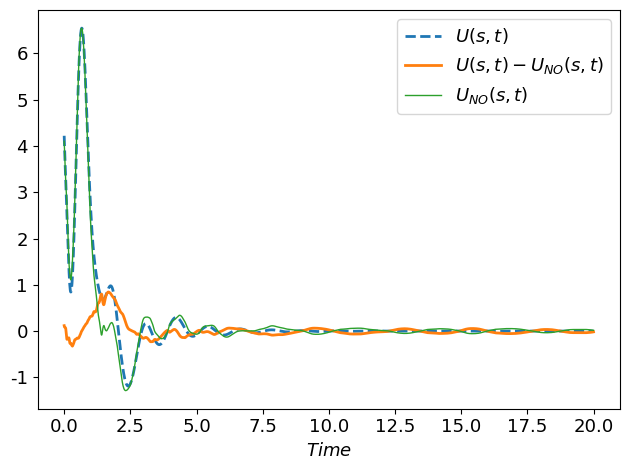

In [14]:
my_dpi = 300
fig_intep=plt.figure(figsize=(800 / my_dpi, 800 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
lossU[:] = UCalc[:] - UEstimate[:] 
fig = plt.figure()
flg, ax = plt.subplots()
time2 = np.linspace(0, final_time, Maxstep)
ax.plot(time2, UCalc, label= r'$U\left(s,t\right)$',linestyle='--', linewidth=2)
ax.plot(time2, lossU, label = r'$U\left(s,t\right)-U_{NO}\left( s,t\right)$', linewidth=2)
ax.plot(time2, UEstimate, label=r'$U_{NO}\left(s,t\right)$', linewidth=1)

plt.xlabel(r'$Time$',fontsize="13")
plt.tick_params(labelsize=13)
fig = plt.gcf()
fig.tight_layout()
plt.legend(loc="best",fontsize="13")
plt.savefig('../picture2/1025/Compare.jpg', dpi=300,bbox_inches='tight')
print(np.abs(lossU[-1]))

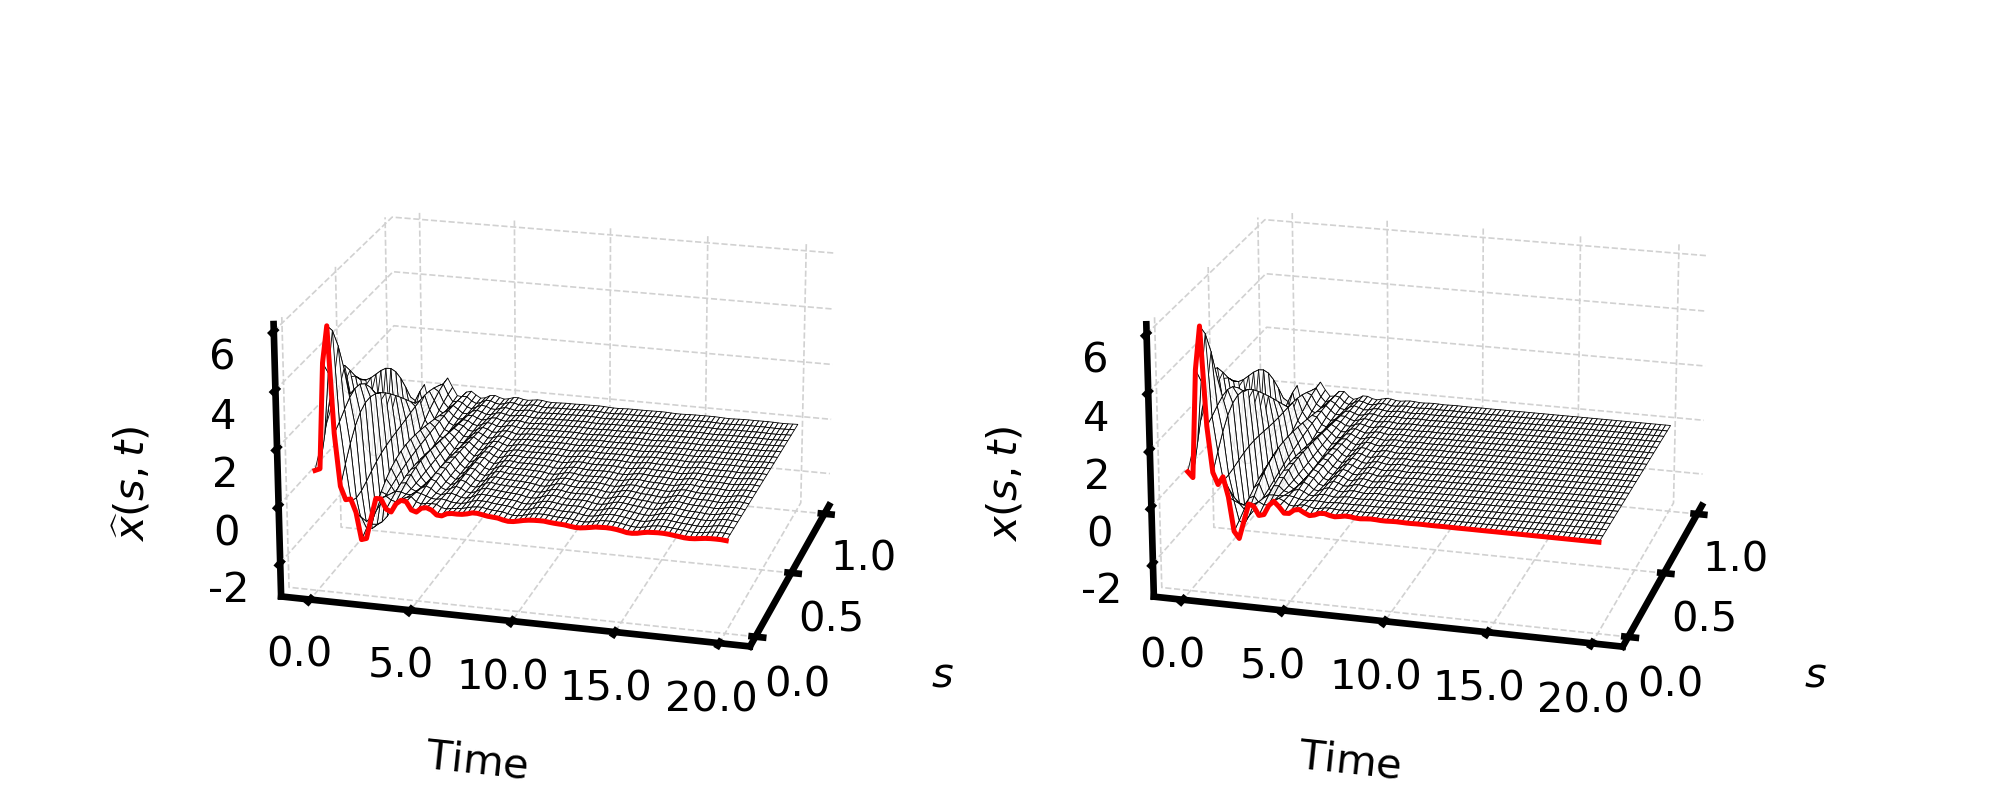

In [15]:
############### draw output
my_dpi=300
# res = 10
draw_rate = 50
nt_draw = Maxstep + 1
temporal_draw=myTime[0:nt_draw:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw, indexing="ij")
test=np.zeros(len(temporal_draw))

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 400 / my_dpi), dpi=600)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig.subplots_adjust(left=0.1, bottom=0, right=0.9, top=0.99, wspace=0.2, hspace=0)


ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    

ax[0].plot_surface(meshx2, mesht2, X[0:nx, 0:nt_draw:draw_rate], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

ax[0].plot(test, temporal_draw, X[0, 0:nt_draw:draw_rate], color="red", lw=0.6, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))

ax[0].view_init(20,15)
ax[0].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[0].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[0].set_zlabel(r"$\widehat{x}(s,t)$",fontsize = 5 , rotation = 90, labelpad=-10)
ax[0].set_xticks([0, 0.5, 1])

ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both', labelsize=5 , pad=-4)  


######################################################


ax[1].plot_surface(meshx2, mesht2, X2[0:nx, 0:nt_draw:draw_rate], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

ax[1].plot(test, temporal_draw, X2[0, 0:nt_draw:draw_rate], color="red", lw=0.6, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))

ax[1].view_init(20, 15)
ax[1].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[1].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[1].set_zlabel(r"$x(s,t)$", fontsize = 5 ,rotation = 90, labelpad=-10)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES
ax[1].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5]) 
ax[1].tick_params(axis='both',  labelsize=5, pad=-4 )  

plt.savefig('../picture2/1025/x_state.jpg', dpi=600)#,bbox_inches='tight'

<Figure size 800x600 with 0 Axes>

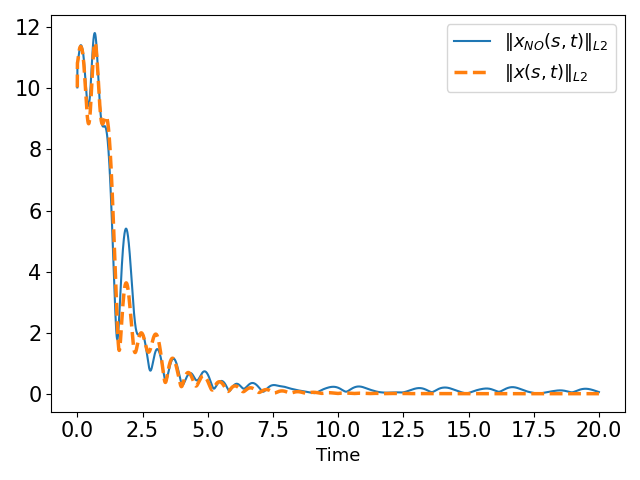

In [16]:
my_dpi = 300
interL = np.linalg.norm(X, axis =0)
interL2 = np.linalg.norm(X2, axis =0)
fig = plt.figure(figsize=(800 / my_dpi, 600 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  
flg, ax = plt.subplots()
time2 = np.linspace(0, final_time, Maxstep+1)
ax.plot(time2, interL, label=r"$\Vert x_{NO}\left(s,t \right) \Vert  _{L2}$", linewidth=1.5)
ax.plot(time2, interL2, label=r"$\Vert x\left(s,t \right) \Vert  _{L2}$",linestyle='--', linewidth=2.5)

plt.xlabel("Time",fontsize="13")
plt.tick_params(labelsize=15)
fig = plt.gcf()
fig.tight_layout()
plt.legend(fontsize="13", loc="best")
plt.savefig('../picture2/1025/L2.jpg', dpi=300,bbox_inches='tight')
plt.show()


<Figure size 800x600 with 0 Axes>

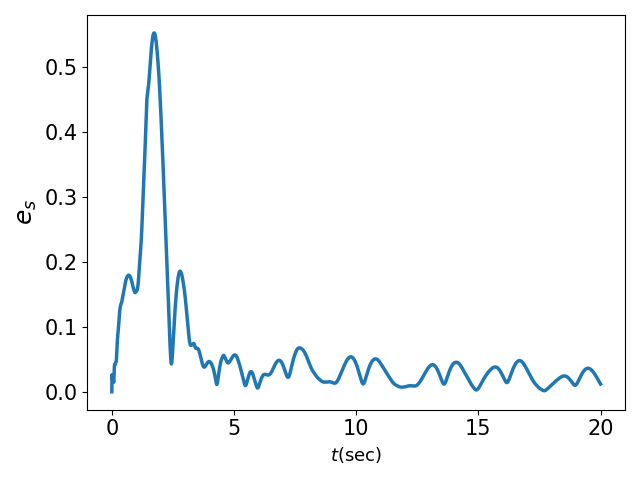

0.01187005481440352


In [17]:
my_dpi = 300
temp = np.sum((X - X2) * (X - X2) * dx, axis=0)
L2Norm = np.sqrt(temp)

fig = plt.figure(figsize=(800 / my_dpi, 600 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  
flg, ax = plt.subplots()
time2 = np.linspace(0, final_time, Maxstep+1)
ax.plot(time2, L2Norm, linewidth=2.5)

plt.xlabel(r'$t(\mathrm{sec})$',fontsize="13")

plt.ylabel(r'$e_s$',fontsize="18")
plt.tick_params(labelsize=15)
fig = plt.gcf()
fig.tight_layout()

plt.savefig('../picture2/1025/L2Norm.jpg', dpi=300,bbox_inches='tight')
plt.show()
print(L2Norm[-1])